In [1]:
from nufeb_tools import utils,plot,spatial
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.signal import find_peaks
from scipy.spatial.distance import pdist,squareform
from scipy.spatial import KDTree
from scipy.spatial import Voronoi, voronoi_plot_2d
#import skgeom as sg
from tqdm import tqdm
from pathlib import Path
from joblib import Parallel, delayed
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
#BASE_DIR = Path(f'../simulation-data/runs')
#folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
#subset = folders[:50]
#test_folders = [r'D:\runs\Run_50_50_10_1_2021-07-27',r'D:\runs\Run_50_50_45_1_2021-07-27',r'D:\runs\Run_50_50_100_1_2021-07-27']
DIR = Path('D:/runs/random')
folders = [path for path in DIR.iterdir() if path.is_dir()]


In [5]:
# Load datasets one at a time
data = [utils.get_data(directory=str(folder)) for folder in sorted(folders)]

Assigning ancestry: 100%|██████████| 350/350 [00:24<00:00, 14.25it/s]


In [6]:
data2 = [spatial.fitness_metrics(x) for x in data]

C:\Users\Jonathan\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Jonathan\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\Jonathan\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

# Gather datasets

In [3]:
def collect_data(folder):
    
    try:
        a = utils.get_data(directory=str(folder))
        b = spatial.fitness_metrics(a)
        return b
    except:
        print('Error in ' + str(folder))
        return

with Parallel(n_jobs=-1) as parallel:
    temp = parallel(delayed(collect_data)(folder) for folder in tqdm(sorted(folders)))
data = pd.concat(temp)
data.to_pickle('saved-metrics.pkl')

 14%|█▍        | 24/172 [00:20<00:11, 12.41it/s]

# Preliminary multiple linear regression

In [8]:
data = pd.concat(data2)
metric2 = data[data.type==2].fillna(0)
import statsmodels.api as sm
metric_list = list(metric2.columns.drop('total biomass'))
y = metric2['total biomass']
def get_stats():
    x = metric2[metric_list]
    results = sm.OLS(y, x).fit()
    print(results.summary())
get_stats()

                            OLS Regression Results                            
Dep. Variable:          total biomass   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     567.3
Date:                Fri, 15 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:41:01   Log-Likelihood:                -6699.8
No. Observations:                 630   AIC:                         1.344e+04
Df Residuals:                     609   BIC:                         1.353e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
mother_cell             

# Plot all possible metrics vs biomass

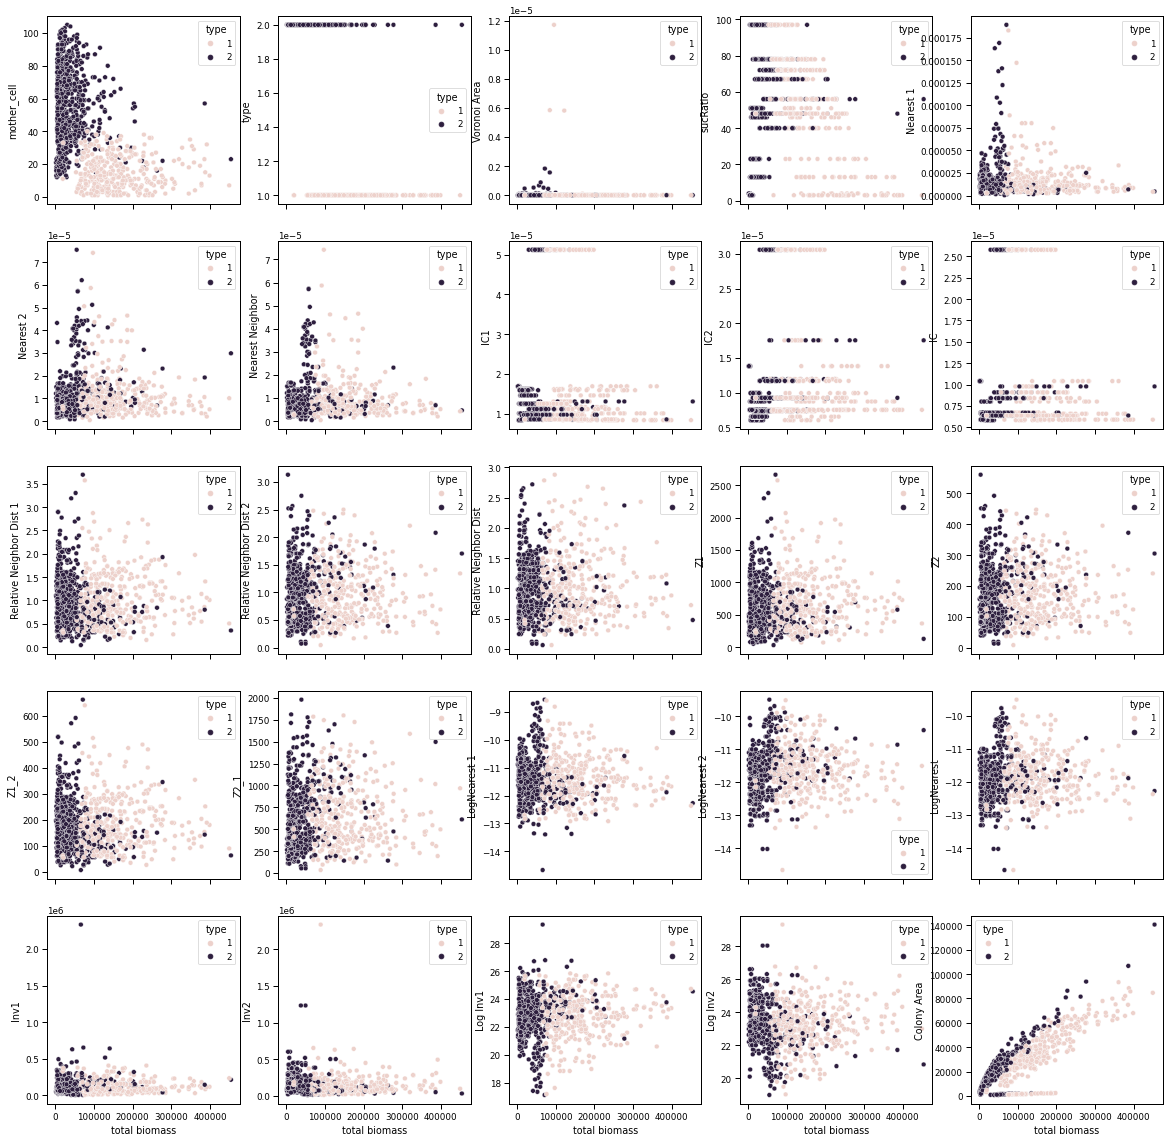

In [9]:

sns.set_context('paper')
f, axes = plt.subplots(nrows = int(np.sqrt(len(metric_list))),ncols=int(np.sqrt(len(metric_list))),figsize=(20,20),sharex=True)
for met,ax in zip(metric_list,axes.ravel()):
   sns.scatterplot(x='total biomass',y=met,hue='type',data=data,ax=ax)
plt.show()
#for ax in axes.ravel():
   # ax.set_xscale('log')
   # ax.set_yscale('log')


# Define backward regression algorithm

In [10]:
def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y,X[included]).fit()
        pvalues = model.pvalues
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included
threshold = 0.01

# Perform backward regression to find the best fitting parameters

In [11]:
stats = list(data.columns.drop(['total biomass','Colony Area']))
reg_mets = backward_regression(data[stats], data['total biomass'], threshold_out=threshold,
                           verbose=True)
reg_mets

Drop mother_cell                    with p-value 0.992406
Drop LogNearest                     with p-value 0.951773
Drop Z2                             with p-value 0.89338
Drop Relative Neighbor Dist 2       with p-value 0.893465
Drop Nearest 1                      with p-value 0.833995
Drop Nearest Neighbor               with p-value 0.658961
Drop IC                             with p-value 0.699063
Drop Inv2                           with p-value 0.472727
Drop Nearest 2                      with p-value 0.44322
Drop LogNearest 2                   with p-value 0.253464
Drop Log Inv2                       with p-value 0.251871
Drop Relative Neighbor Dist         with p-value 0.140207
Drop Relative Neighbor Dist 1       with p-value 0.675881
Drop Voronoi Area                   with p-value 0.0929325
Drop Z2_1                           with p-value 0.0418624
Drop Z1                             with p-value 0.0380094
Drop Inv1                           with p-value 0.0221945


['type', 'sucRatio', 'IC1', 'IC2', 'Z1_2', 'LogNearest 1', 'Log Inv1']

# Check the resulting fit

In [12]:
y = data['total biomass']
X = data[reg_mets]
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print(model.summary())


                                 OLS Regression Results                                
Dep. Variable:          total biomass   R-squared (uncentered):                   0.774
Model:                            OLS   Adj. R-squared (uncentered):              0.773
Method:                 Least Squares   F-statistic:                              549.0
Date:                Fri, 15 Oct 2021   Prob (F-statistic):                   1.56e-306
Time:                        17:41:06   Log-Likelihood:                         -11939.
No. Observations:                 968   AIC:                                  2.389e+04
Df Residuals:                     962   BIC:                                  2.392e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

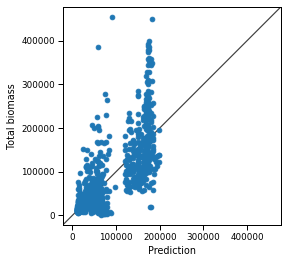

In [13]:
f, ax = plt.subplots()

ax.scatter(predictions,y)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Prediction')
ax.set_ylabel('Total biomass')
plt.show()

# Regression with scaled metrics

In [14]:

scaler = StandardScaler()
metric_list = list(data.columns.drop(['total biomass','Colony Area']))
to_scale = list(data.columns)
scaled_df = data.copy()
scaled_df[to_scale] = scaler.fit_transform(data[to_scale])
scaled_df

,mother_cell,type,Voronoi Area,sucRatio,total biomass,Nearest 1,Nearest 2,Nearest Neighbor,IC1,IC2,...,Z1_2,Z2_1,LogNearest 1,LogNearest 2,LogNearest,Inv1,Inv2,Log Inv1,Log Inv2,Colony Area
0,-0.619873,0.732467,-0.070314,-1.733121,-0.940627,-0.662799,2.519137,-0.635664,0.080269,0.421847,...,-1.447100,0.800405,-1.523605,2.072096,-0.934798,1.421346,-0.942173,1.523605,-2.072096,-1.022261
1,-0.657340,0.732467,-0.068770,-1.733121,-0.975389,-0.387442,-0.203818,-0.000112,0.080269,0.421847,...,-0.890609,-1.128161,-0.369830,0.085405,0.370508,0.009585,-0.291568,0.369830,-0.085405,-1.026105
2,-1.069479,0.732467,-0.072852,-1.733121,-0.958851,-0.178700,-0.686843,-0.563111,0.080269,0.421847,...,-0.468745,-1.470269,0.117337,-0.973032,-0.715457,-0.306218,0.642055,-0.117337,0.973032,-0.938065
3,-0.769742,0.732467,-0.071564,-1.733121,-0.961139,0.278348,0.140111,0.424894,0.080269,0.421847,...,0.454940,-0.884569,0.803213,0.541559,0.866159,-0.595187,-0.526578,-0.803213,-0.541559,-0.912106
4,-0.994545,0.732467,-0.069587,-1.733121,-0.948016,-0.212324,-0.686843,-0.563111,0.080269,0.421847,...,-0.536700,-1.470269,0.049842,-0.973032,-0.715457,-0.268987,0.642055,-0.049842,0.973032,-0.860451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,-0.207734,-1.365249,-0.073529,-0.109340,1.047482,-0.257317,-0.064449,0.180496,-0.601264,-0.226855,...,0.562894,0.490947,-0.046122,0.287741,0.601108,-0.212729,-0.404929,0.046122,-0.287741,0.327143
73,-0.582406,-1.365249,-0.073428,-0.109340,1.786189,-0.257317,-0.455369,-0.286557,-0.601264,-0.226855,...,0.562894,-0.339019,-0.046122,-0.370950,-0.086732,-0.212729,0.030030,0.046122,0.370950,0.704210
74,-1.144413,-1.365249,-0.073466,-0.109340,1.134501,-0.717271,-0.975463,-0.907940,-0.601264,-0.226855,...,-1.267111,-1.443231,-1.944531,-2.454067,-2.262032,2.322302,3.831304,1.944531,2.454067,0.228730
75,-0.507471,-1.365249,-0.073303,-0.109340,-0.105939,-0.717271,-0.700091,-0.761392,-0.601264,-0.226855,...,-1.267111,-0.858588,-1.944531,-1.016341,-1.411006,2.322302,0.696611,1.944531,1.016341,-0.763828


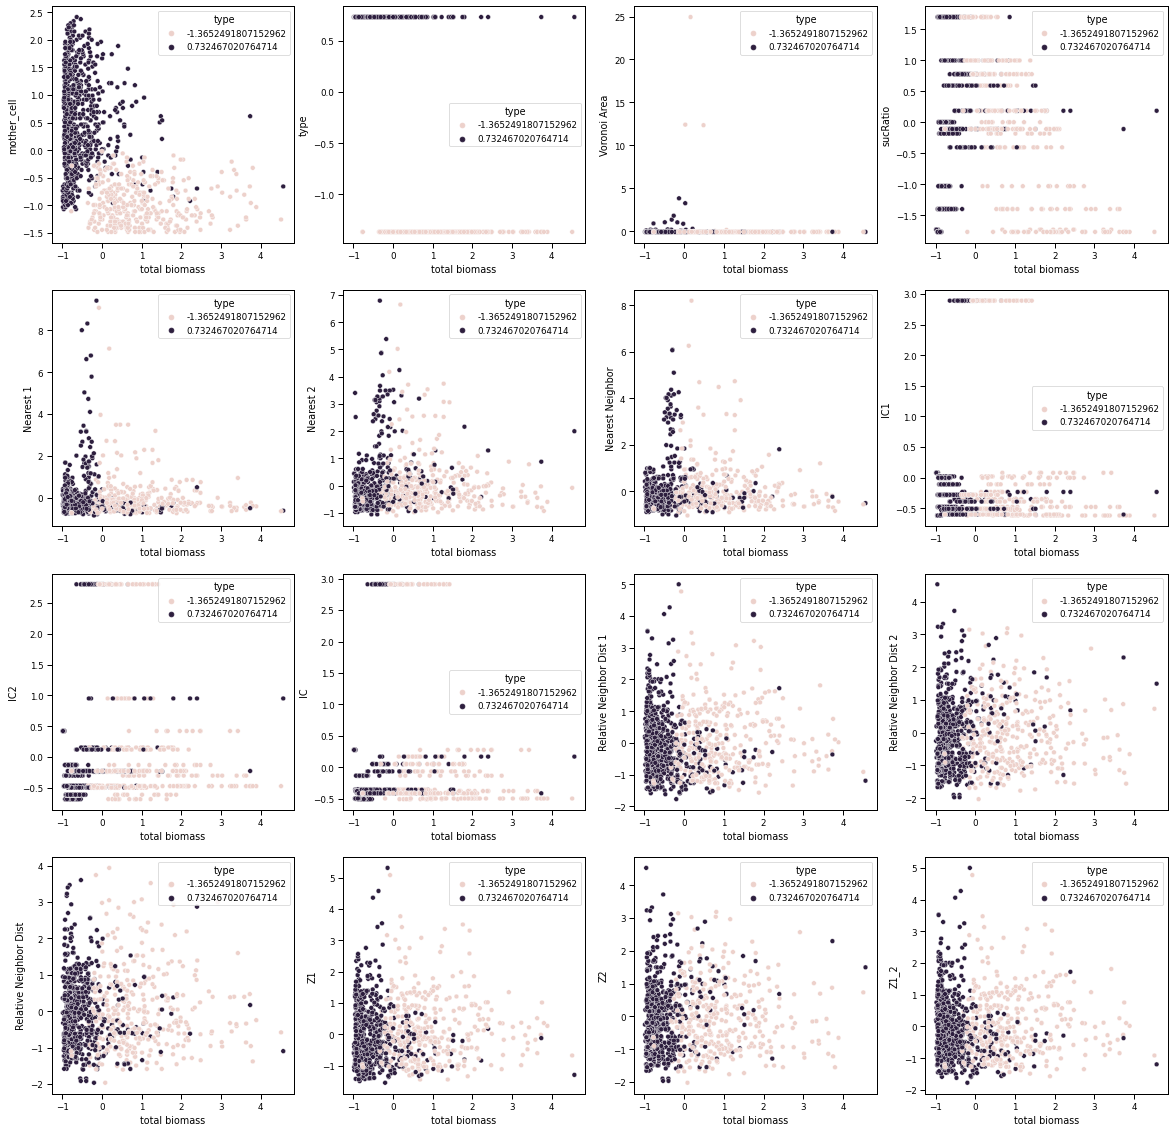

In [15]:
f, axes = plt.subplots(nrows = int(np.sqrt(len(metric_list))),ncols=int(np.sqrt(len(metric_list))),figsize=(20,20))
for met,ax in zip(metric_list,axes.ravel()):
   sns.scatterplot(x='total biomass',y=met,hue='type',data=scaled_df,ax=ax)
plt.show()

In [16]:
stats = list(data.columns.drop(['total biomass','Colony Area']))
reg_mets = backward_regression(scaled_df[stats], scaled_df['total biomass'], threshold_out=threshold,
                           verbose=True)


Drop Inv2                           with p-value 0.980458
Drop Relative Neighbor Dist 2       with p-value 0.961771
Drop Z2                             with p-value 0.961771
Drop Nearest 1                      with p-value 0.876881
Drop Log Inv1                       with p-value 0.873465
Drop LogNearest 1                   with p-value 0.873465
Drop mother_cell                    with p-value 0.844269
Drop LogNearest                     with p-value 0.755416
Drop LogNearest 2                   with p-value 0.760611
Drop Log Inv2                       with p-value 0.760611
Drop Nearest Neighbor               with p-value 0.696482
Drop IC                             with p-value 0.61314
Drop Nearest 2                      with p-value 0.581665
Drop Inv1                           with p-value 0.278
Drop Relative Neighbor Dist 1       with p-value 0.109144
Drop Z1_2                           with p-value 0.109144
Drop Relative Neighbor Dist         with p-value 0.275825
Drop Voronoi Area 

In [17]:
y = scaled_df['total biomass']
X = scaled_df[reg_mets]
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:          total biomass   R-squared (uncentered):                   0.549
Model:                            OLS   Adj. R-squared (uncentered):              0.547
Method:                 Least Squares   F-statistic:                              234.8
Date:                Fri, 15 Oct 2021   Prob (F-statistic):                   6.44e-164
Time:                        17:41:08   Log-Likelihood:                         -987.69
No. Observations:                 968   AIC:                                      1985.
Df Residuals:                     963   BIC:                                      2010.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

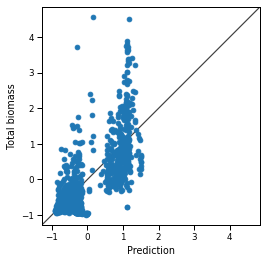

In [18]:
f, ax = plt.subplots()

ax.scatter(predictions,y)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Prediction')
ax.set_ylabel('Total biomass')
plt.show()

# E. coli analysis

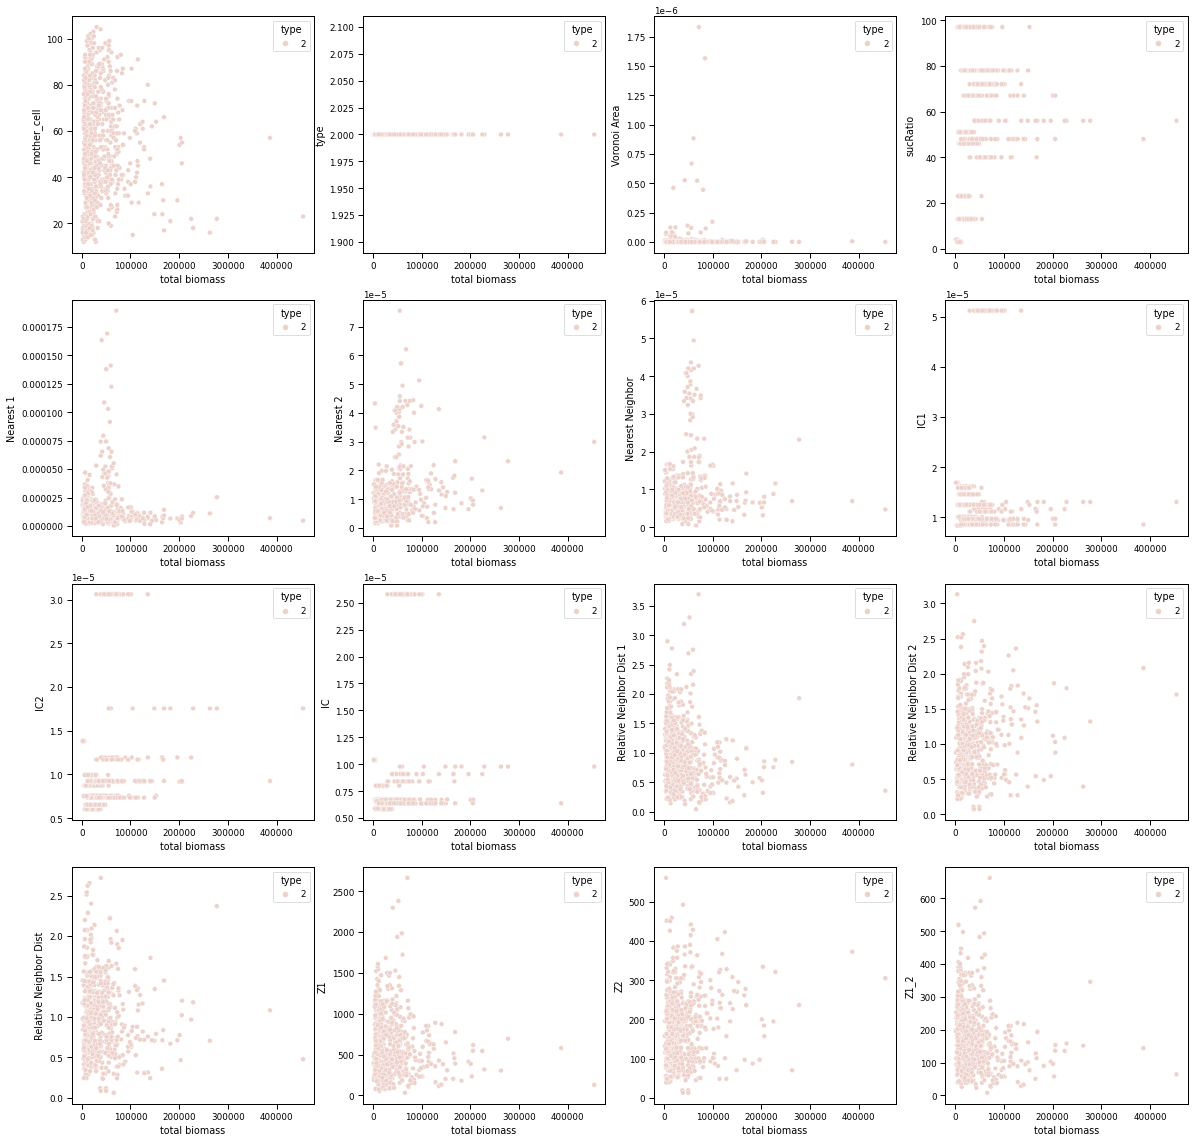

In [19]:
data2 = data[data.type==2]
stats = list(data2.columns.drop(['total biomass','Colony Area']))
f, axes = plt.subplots(nrows = int(np.sqrt(len(stats))),ncols=int(np.sqrt(len(stats))),figsize=(20,20))
for met,ax in zip(stats,axes.ravel()):
   sns.scatterplot(x='total biomass',y=met,hue='type',data=data2,ax=ax)
plt.show()

In [20]:
reg_mets = backward_regression(data2[stats], data2['total biomass'], threshold_out=threshold,
                           verbose=True)
reg_mets

Drop LogNearest 1                   with p-value 0.94975
Drop Log Inv1                       with p-value 0.945948
Drop type                           with p-value 0.935139
Drop Z2                             with p-value 0.887571
Drop Relative Neighbor Dist 1       with p-value 0.965061
Drop Relative Neighbor Dist 2       with p-value 0.888281
Drop Voronoi Area                   with p-value 0.678504
Drop mother_cell                    with p-value 0.640425
Drop Inv2                           with p-value 0.385216
Drop Nearest Neighbor               with p-value 0.305697
Drop Nearest 2                      with p-value 0.5513
Drop Z1_2                           with p-value 0.32302
Drop Z2_1                           with p-value 0.222933
Drop Relative Neighbor Dist         with p-value 0.0584535
Drop IC1                            with p-value 0.0614732


['sucRatio',
 'Nearest 1',
 'IC2',
 'IC',
 'Z1',
 'LogNearest 2',
 'LogNearest',
 'Inv1',
 'Log Inv2']

In [21]:
y = data2['total biomass']
X = data2[reg_mets]
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:          total biomass   R-squared (uncentered):                   0.725
Model:                            OLS   Adj. R-squared (uncentered):              0.722
Method:                 Least Squares   F-statistic:                              205.4
Date:                Fri, 15 Oct 2021   Prob (F-statistic):                   5.04e-169
Time:                        17:41:11   Log-Likelihood:                         -7417.4
No. Observations:                 630   AIC:                                  1.485e+04
Df Residuals:                     622   BIC:                                  1.489e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

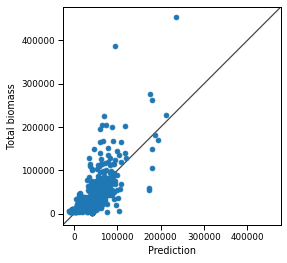

In [22]:
f, ax = plt.subplots()

ax.scatter(predictions,y)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Prediction')
ax.set_ylabel('Total biomass')
plt.show()

In [23]:
scaled_df2 = data2.copy()
scaled_df2[to_scale] = scaler.fit_transform(data2[to_scale])
scaled_df2

,mother_cell,type,Voronoi Area,sucRatio,total biomass,Nearest 1,Nearest 2,Nearest Neighbor,IC1,IC2,...,Z1_2,Z2_1,LogNearest 1,LogNearest 2,LogNearest,Inv1,Inv2,Log Inv1,Log Inv2,Colony Area
0,-1.366388,0.0,-0.114246,-1.804816,-0.778853,-0.663583,2.501589,-0.627779,0.035807,0.460075,...,-1.437716,0.840497,-1.555856,2.103307,-0.918031,1.281103,-1.099021,1.555856,-2.103307,-0.857997
1,-1.411367,0.0,-0.107836,-1.804816,-0.842445,-0.392536,-0.182113,0.025460,0.035807,0.460075,...,-0.868766,-1.078681,-0.396277,0.122200,0.404325,0.016840,-0.354705,0.396277,-0.122200,-0.862945
2,-1.906146,0.0,-0.124791,-1.804816,-0.812191,-0.187060,-0.658175,-0.553207,0.035807,0.460075,...,-0.437457,-1.419124,0.093341,-0.933262,-0.695825,-0.265969,0.713395,-0.093341,0.933262,-0.749617
3,-1.546307,0.0,-0.119441,-1.804816,-0.816376,0.262835,0.156858,0.462295,0.035807,0.460075,...,0.506907,-0.836275,0.782667,0.577072,0.906451,-0.524747,-0.623565,-0.782667,-0.577072,-0.716202
4,-1.816186,0.0,-0.111231,-1.804816,-0.792370,-0.220159,-0.658175,-0.553207,0.035807,0.460075,...,-0.506933,-1.419124,0.025507,-0.933262,-0.695825,-0.232628,0.713395,-0.025507,0.933262,-0.649709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,-0.601730,0.0,-0.123758,-0.155854,0.948846,-0.417854,-0.563436,-0.435166,-0.646523,-0.176632,...,-0.016661,-0.579343,-0.471014,-0.653310,-0.398831,0.069751,0.350861,0.471014,0.653310,0.760456
33,-0.376831,0.0,-0.124837,-0.155854,3.709972,-0.514698,-0.118613,-0.268957,-0.646523,-0.176632,...,-0.416860,0.374211,-0.802469,0.218967,-0.058887,0.343117,-0.419152,0.802469,-0.218967,3.076298
34,0.297866,0.0,-0.100075,-0.155854,1.910577,-0.499038,-0.563436,-0.435166,-0.646523,-0.176632,...,-0.352149,-0.579343,-0.743054,-0.653310,-0.398831,0.289056,0.350861,0.743054,0.653310,1.357463
35,0.837625,0.0,-0.126209,-0.155854,1.986648,-0.759542,0.649580,-0.859044,-0.646523,-0.176632,...,-1.428658,2.020967,-2.442221,1.056249,-1.928819,3.315563,-0.829006,2.442221,-1.056249,1.891706


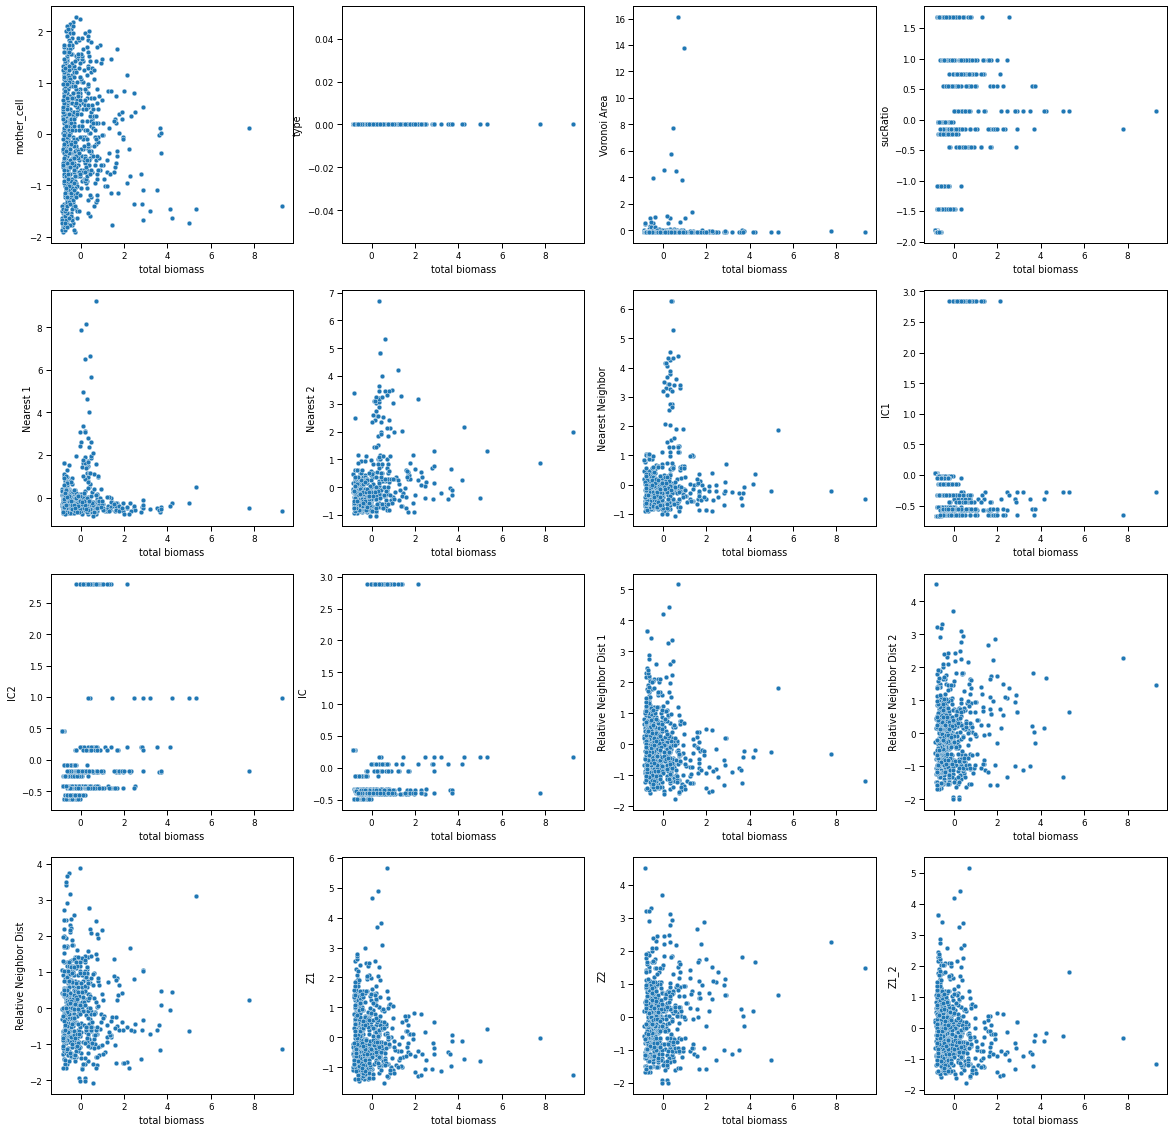

In [24]:
f, axes = plt.subplots(nrows = int(np.sqrt(len(stats))),ncols=int(np.sqrt(len(stats))),figsize=(20,20))
for met,ax in zip(stats,axes.ravel()):
   sns.scatterplot(x='total biomass',y=met,data=scaled_df2,ax=ax)
plt.show()

In [25]:
reg_mets = backward_regression(scaled_df2[stats], scaled_df2['total biomass'], threshold_out=threshold,
                           verbose=True)
reg_mets

Drop LogNearest 1                   with p-value 0.945905
Drop Log Inv1                       with p-value 0.945905
Drop Z2                             with p-value 0.879914
Drop Relative Neighbor Dist 2       with p-value 0.879914
Drop Voronoi Area                   with p-value 0.676424
Drop mother_cell                    with p-value 0.640596
Drop Inv2                           with p-value 0.675977
Drop Nearest Neighbor               with p-value 0.332842
Drop Nearest 2                      with p-value 0.462133
Drop Z1_2                           with p-value 0.331555
Drop Relative Neighbor Dist 1       with p-value 0.331555
Drop Z2_1                           with p-value 0.264862
Drop Relative Neighbor Dist         with p-value 0.141415
Drop IC1                            with p-value 0.048477


['type',
 'sucRatio',
 'Nearest 1',
 'IC2',
 'IC',
 'Z1',
 'LogNearest 2',
 'LogNearest',
 'Inv1',
 'Log Inv2']

In [26]:
y = scaled_df2['total biomass']
X = scaled_df2[reg_mets]
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:          total biomass   R-squared (uncentered):                   0.504
Model:                            OLS   Adj. R-squared (uncentered):              0.498
Method:                 Least Squares   F-statistic:                              79.08
Date:                Fri, 15 Oct 2021   Prob (F-statistic):                    1.11e-89
Time:                        17:41:13   Log-Likelihood:                         -672.90
No. Observations:                 630   AIC:                                      1362.
Df Residuals:                     622   BIC:                                      1397.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

C:\Users\Jonathan\anaconda3\envs\nufeb\lib\site-packages\statsmodels\regression\linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


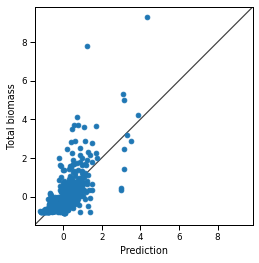

In [27]:
f, ax = plt.subplots()

ax.scatter(predictions,y)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Prediction')
ax.set_ylabel('Total biomass')
plt.show()

In [28]:
#RECURSIVE FEATURE ELIMINATION
#Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
names=pd.DataFrame(X.columns)

#use linear regression as the model
lin_reg = LinearRegression()

#This is to select 5 variables: can be changed and checked in model for accuracy
rfe_mod = RFE(lin_reg, 5, step=1) #RFECV(lin_reg, step=1, cv=5) 
myvalues=rfe_mod.fit(X,y) #to fit
myvalues.support_#The mask of selected features.
myvalues.ranking_ #The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1.

rankings=pd.DataFrame(myvalues.ranking_) #Make it into data frame
#Concat and name columns
ranked=pd.concat([names,rankings], axis=1)
ranked.columns = ["Feature", "Rank"]
ranked

#Select most important (Only 1's)
most_important = ranked.loc[ranked['Rank'] ==1] 
print(most_important)

most_important['Rank'].count()

        Feature  Rank
1      sucRatio     1
3           IC2     1
4            IC     1
6  LogNearest 2     1
7    LogNearest     1


C:\Users\Jonathan\anaconda3\envs\nufeb\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


5

In [29]:
lin_reg.fit(X,y)
print('Intercept: \n', lin_reg.intercept_)
print('Coefficients: \n', lin_reg.coef_)

Intercept: 
 -2.957469074742916e-16
Coefficients: 
 [ 0.          0.41446373  0.16391335  3.74788442 -3.72204727 -0.29803161
  0.24102256 -0.42017087 -0.16708807 -0.24102256]
